In [3]:
!pip install iisignature
!pip install signatory

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245484 sha256=87559df246835c3247836963d266c4e077050e3b7a8eafd13ce34c9df0603e90
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp310-cp310-linux_x86_64.whl size=11874852 sha256=5179c79a05aa09aeeb29139f876aef2d3c23d0075790e537ddf3b42e2a5adaf9
  Stored in directory: /root/.cache/pip/wheels/71/b4/17/46d769da4808e9f83f9790a2b805f81f43ececc2c02f5b1e62
Successfully built signatory


In [4]:
import signatory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "Computer Modern Roman"
#})
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
local = False
if local:
  import sys
    # Add the directory containing TDA_utils.py to the Python path
  sys.path.append('H://Mon Drive/Etude_Cancer')
else:
  %cd /content/drive/MyDrive/Etude_Cancer


from pga import pga

if local:
  path = 'H://Mon Drive/Etude_Cancer/TDA/Simul/benign_dwi_b'
else:
  path = "./Simul/benign_dwi_b"

/content/drive/MyDrive/Etude_Cancer


In [8]:
data = {}
for b in [0.1,0.12,0.14,0.17]:
  df = pd.read_csv(path+str(b)+".csv",sep = ";")
  df_numpy = df.to_numpy().T[:,:,None]
  data[str(b)]= torch.tensor(pd.read_csv(path+str(b)+".csv",sep = ";").to_numpy().T[:,:,None])

In [9]:
scale = False
Time = True


data_ben = torch.cat((data['0.1'][1:,1:],data['0.12'][1:,1:],data['0.14'][1:,1:],data['0.17'][1:,1:]))
average = data_ben.mean(axis=1)[:,0]
data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T
if scale:
  data_ben = data_ben/np.abs(data_ben[:,:,0]).max(dim = 1)[0][:,None,None]

T=1800
time = torch.tensor([300*i for i in range(7)])[None,:,None]/T
times = time.repeat(data_ben.shape[0],1,1)
if Time:
  data_ben= torch.cat((times,data_ben),axis = -1)[:,:]

idx = [i for i in range(10)]
idx = idx+[1000+i for i in range(10)]+[2000+i for i in range(10)]
#plt.plot(data_ben[idx,:,0].T,data_ben[idx,:,1].T)

<ipython-input-9-40c0c76bfeae>:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T


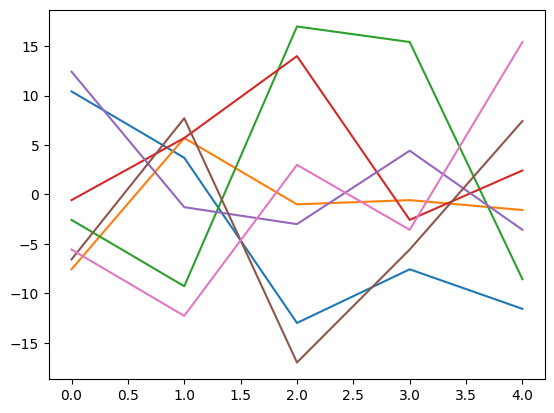

In [52]:
plt.plot(data_ben[:5,:,1].numpy())

In [10]:
import os
import re

if local:
  directory = 'H://Mon Drive/Etude_Cancer/TDA/Simul/'
else:
  directory = "./Simul/"

def starts_with_benign(s):
    return s.startswith("benign")
def starts_with_desktop(s):
    return s.startswith("desktop")

classif = []
data_ben_mal = {}
#directory = './Simul'
for filename in os.listdir(directory):
    if starts_with_benign(filename):
      i = 1
    else:
      if starts_with_desktop(filename):
        i = 1
      else:
        f = os.path.join(directory, filename)
        data_ben_mal[filename]= torch.tensor(pd.read_csv(f,sep = ";").to_numpy().T[:,:,None])


In [11]:
data_mal = torch.cat(tuple([data_ben_mal[filename][1:] for filename in data_ben_mal.keys()]))
average = data_mal.mean(axis=1)[:,0]
data_mal = (data_mal.T-data_mal.mean(axis=1)[:,0]).T
if scale:
  data_mal = data_mal/np.abs(data_mal[:,:,0]).max(dim = 1)[0][:,None,None]

T=1800
time = torch.tensor([300*i for i in range(7)])[None,:,None]/T
times = time.repeat(data_mal.shape[0],1,1)
if Time:
  data_mal= torch.cat((times,data_mal),axis = -1)[:,:]

idx = [i for i in range(10)]
idx = idx+[1000+i for i in range(10)]+[2000+i for i in range(10)]
#plt.plot(data_mal[idx,:,0].T,data_mal[idx,:,1].T)
print(data_mal.shape)

torch.Size([66000, 7, 2])


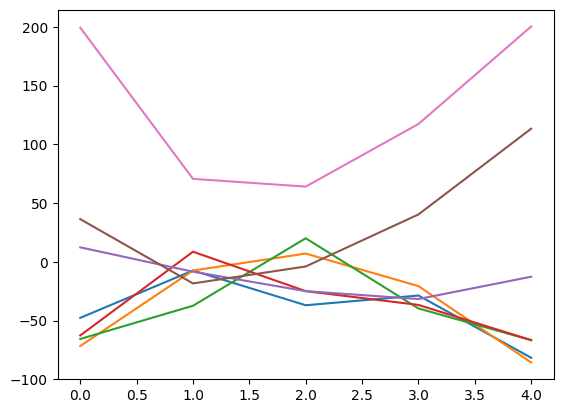

In [56]:
plt.plot(data_mal[:5,:,1].numpy())

# PGA

In [12]:
from pga import pga
from pga import tangent_pga

from pga import recenter_group_elems
from pga import d2h
from utils import depth_inds

from scipy.optimize import fsolve

def compute_pga(path, sig_level, tangent = True, n_components = 3):
  print('Computing signatures')
  sig = signatory.Signature(depth  = sig_level)
  signatures = sig(path,basepoint = True)
  channels = path.shape[-1]

  if tangent:
      print('Computing tangent pga')
      t_principal_directions = tangent_pga(signatures.numpy(), channels, sig_level, n_components=n_components)
  else:
      print('Computing pga')
      t_principal_directions = pga(signatures.numpy(), channels, sig_level, n_components=n_components)
  return t_principal_directions, signatures


def compute_projection(t_principal_directions,path,channels,depth):
  print('Computing tangent pga projections')
  channels = path.shape[-1]
  inds = depth_inds(channels, depth)
  sig = signatory.Signature(depth  = depth)
  signatures = sig(path,basepoint = True)
  projections_t = {}
  n_components = len(t_principal_directions)
  for K in range(n_components):
      optimized_v_t = t_principal_directions[K]
      SXk = recenter_group_elems(signatures.numpy(), channels, depth, inds)
      tis_t = []
      for i in range(len(signatures.numpy())):
          d2h_t = lambda t: d2h(t, optimized_v_t, SXk[i], depth, channels)
          initial_guess_t = 0.
          optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]
          tis_t.append(optimized_ti_t)
          print(f'Data #{i} with component #{K}')
      tis_t = np.array(tis_t)
      projections_t[K] = tis_t
  var_t = [np.var(projections_t[k]) for k in range(n_components)]
  print('Variance expliquée par les 3 premières géodésiques principales'+str(var_t))

  return projections_t

def visualisation_normales(projections,colour):


  for pg in range(1,len(projections)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(projections[0])):
        ax.scatter(projections[0][i],projections[pg][i], color=colour[i])
    plt.title('Data vizualisation on the two first principal geodesics')
    plt.xlabel("PG1")
    plt.ylabel(f"PG{pg+1}")
    plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111,projection = '3d')

  for i in range(len(projections[0])):
      ax.scatter(projections[0][i],projections[1][i],projections[2][i] , color=colour[i])
  plt.title('Visualisation des données sur les 3 premières géodésiques')
  plt.show()

def visualisation_all(projections_norm,projections_anorm,rate,num):

  for pg in range(1,len(projections_norm)):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(projections_norm[0],projections_norm[pg], color=['blue'],label = "Benign")
    ax.scatter(projections_anorm[0],projections_anorm[pg], color=['red'],label = "Malignant")

    plt.title(f'Data vizualisation on the first and {pg}th principal geodesics')
    plt.xlabel("PG1")
    plt.ylabel(f"PG{pg+1}")
    plt.legend()
    plt.show()

def visualisation_mal(projections_anorm):
  for pg in range(1,len(projections_anorm[0])):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for rate in range(6):
      ax.scatter(projections_anorm[i][0],projections_anorm[i][pg], color=['red'])
    plt.title(f'Data vizualisation on the first and {pg}th principal geodesics')
    plt.xlabel("PG1")
    plt.ylabel(f"PG{pg+1}")
    plt.show()


def leadlag(X):
        '''
        lead-lag transformation of one dimensional TS [T,1] -> [2T-1, 2]

        Parameters
        ----------
        X : tensor
        Time serie tensor of size [1,T,1]

        Returns
        -------
        TS_ll : tensor
            Time serie tensor of size [1,2T-1,2]

            '''
        T = X.shape[-2]
        d = X.shape[-1]
        batch = X.shape[0
                        ]
        # Initiate path
        lead_lag = np.empty([batch,(T-1)*2+1,d*2])
        lead_lag_pair = np.tile(X,2)
        print(X.shape)
        print(np.insert(X,0,0,axis = 1).shape)
        zeros_beg = np.insert(X,0,0,axis=1).reshape([batch,T+1,d])
        lead_lag_impair = np.concatenate((np.insert(X,T,0,axis=1),zeros_beg),axis=-1)

        for t in range(T-1):
            #When t' = 2t, LL = [X_1(t),X_2(t),...,X_n(t),X_1(t),X_2(t),...,X_n(t)]
            lead_lag[:,2*t] = lead_lag_pair[:,t,:]
            #When t' = 2t+1, LL = [X_1(t+1),X_2(t+1),...,X_n(t+1),X_1(t),X_2(t),...,X_n(t)]
            lead_lag[:,2*t+1] = lead_lag_impair[:,t+1,:]
        lead_lag[:,-1] = lead_lag_pair[:,-1]
        return torch.tensor(lead_lag)

In [ ]:
data_ben_temp = data_ben
data_mal_temp = data_mal

In [ ]:
data_ben = data_ben_temp
data_mal = data_mal_temp

In [13]:
##### Rescaling #####
rescale = False
lead_lag = False



M = data_ben.max()
m = data_ben.min()

f = lambda X: (X-m)/(M-m)

if rescale:
  data_ben = f(data_ben)
  data_mal = f(data_mal)

print(data_ben.shape)
if lead_lag:
  data_ben = leadlag(data_ben)#[:,:,0:1])
  data_mal = leadlag(data_mal)#[:,:,0:1])

print(data_ben.shape)

torch.Size([4000, 7, 2])
torch.Size([4000, 7, 2])


In [14]:
idx_ben = [i for i in range(100)]
for j in range(1,3):
  idx_ben  += [1000*j + i for i in range(100)]
t_principal_directions, signatures_ben = compute_pga(path = data_ben[idx_ben],sig_level=3,tangent=True,n_components = 10)

Computing signatures
Computing tangent pga


In [15]:
projections_ben = compute_projection(t_principal_directions,data_ben,channels = data_ben.shape[-1],depth = 3)

Computing tangent pga projections
Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0
Data #4 with component #0


<ipython-input-12-8bc71d05dc54>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Data #3001 with component #8
Data #3002 with component #8
Data #3003 with component #8
Data #3004 with component #8
Data #3005 with component #8
Data #3006 with component #8
Data #3007 with component #8
Data #3008 with component #8
Data #3009 with component #8
Data #3010 with component #8
Data #3011 with component #8
Data #3012 with component #8
Data #3013 with component #8
Data #3014 with component #8
Data #3015 with component #8
Data #3016 with component #8
Data #3017 with component #8
Data #3018 with component #8
Data #3019 with component #8
Data #3020 with component #8
Data #3021 with component #8
Data #3022 with component #8
Data #3023 with component #8
Data #3024 with component #8
Data #3025 with component #8
Data #3026 with component #8
Data #3027 with component #8
Data #3028 with component #8
Data #3029 with component #8
Data #3030 with component #8
Data #3031 with component #8
Data #3032 with compone

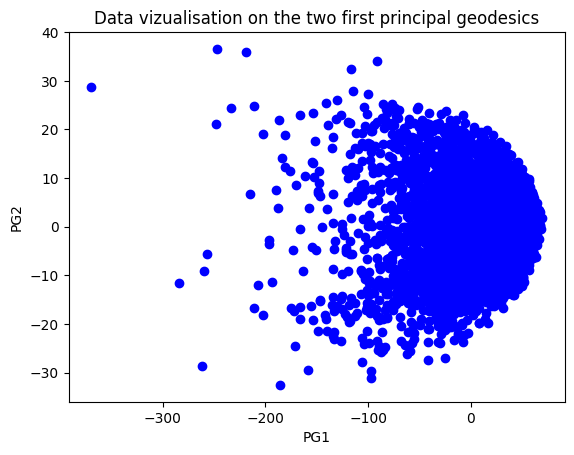

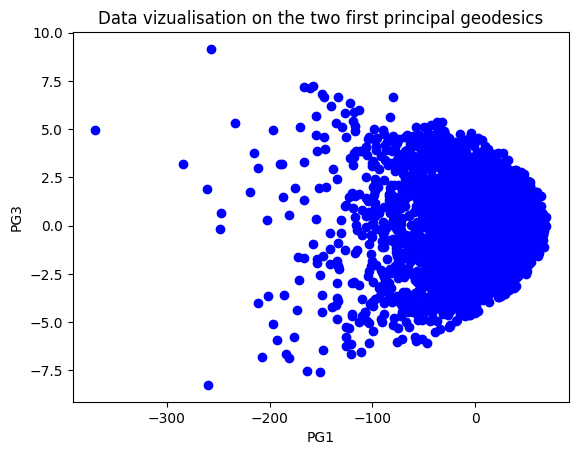

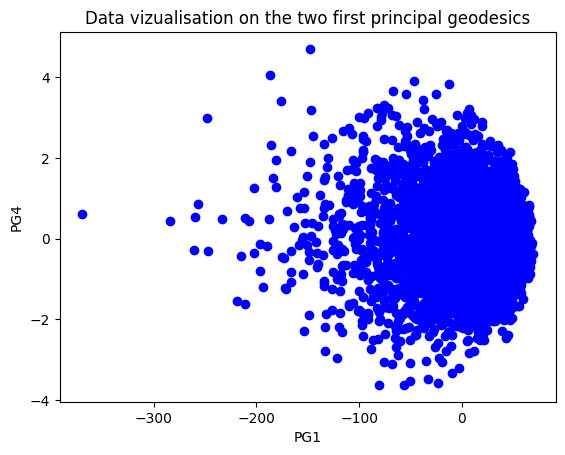

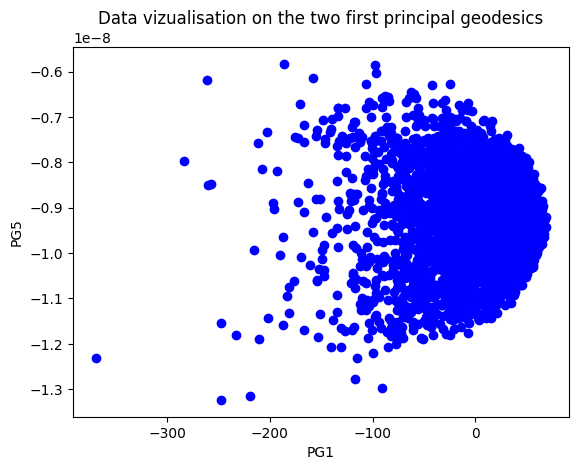

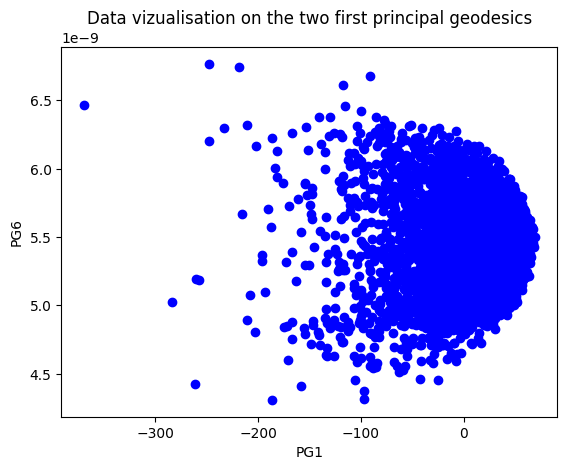

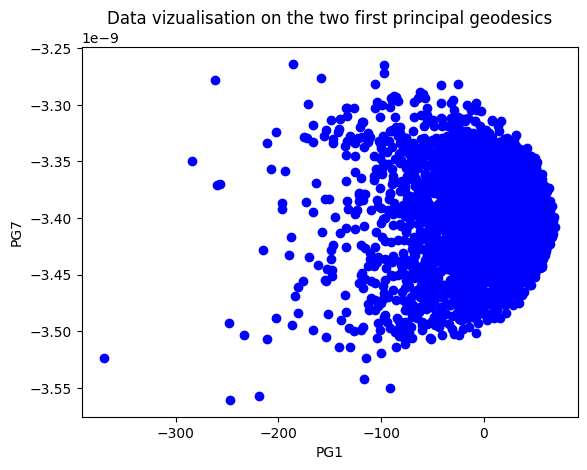

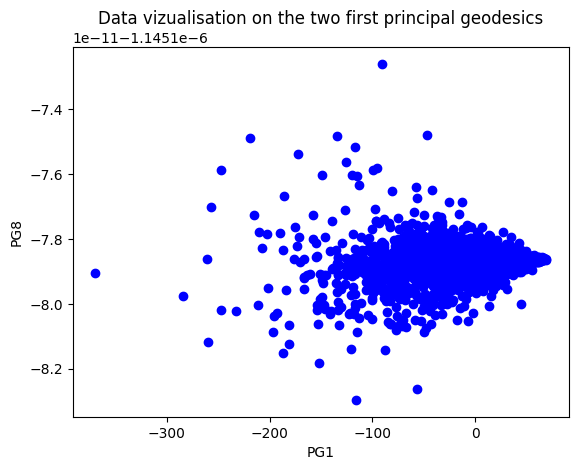

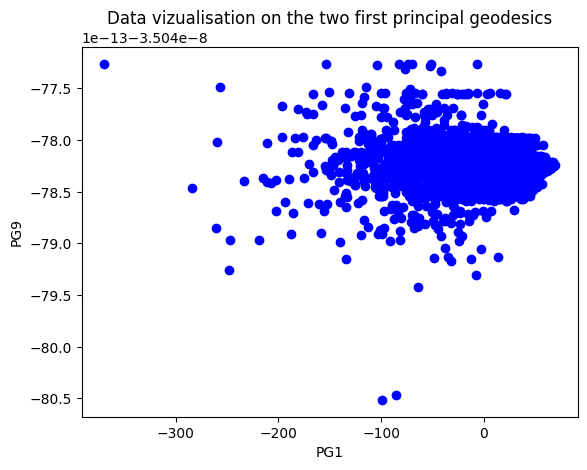

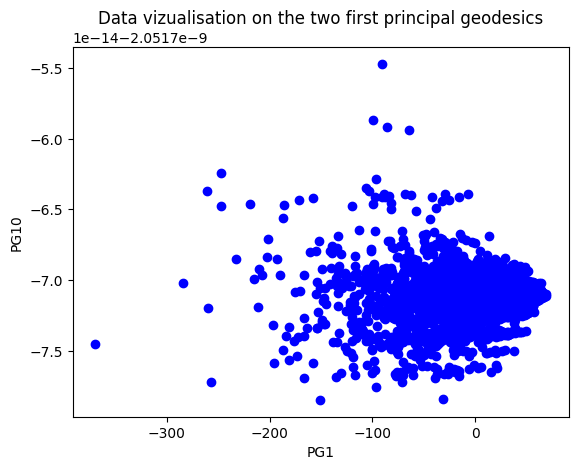

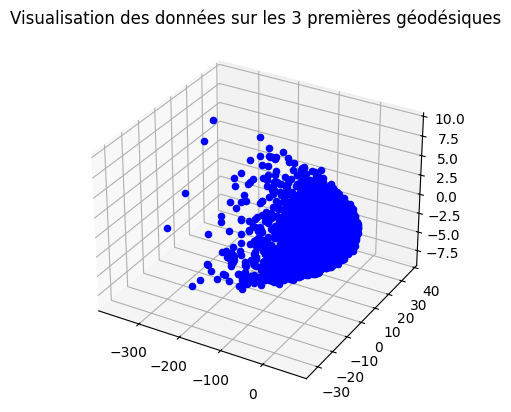

In [16]:
visualisation_normales(projections_ben,colour = ['blue']*len(projections_ben[0]))

In [17]:
idx_mal = {}
idx_mal[0] = np.array([i for i in range(20)])
for j in range(1,36):
  idx_mal[j] = np.array([j*1000+i for i in range(20)])

In [18]:
projections_mal = {}
for i in range(36):
  projections_mal[i] = compute_projection(t_principal_directions,data_mal[idx_mal[i]],channels = data_mal.shape[-1],depth = 3)

Computing tangent pga projections
Data #0 with component #0


<ipython-input-12-8bc71d05dc54>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Data #9 with component #2
Data #10 with component #2
Data #11 with component #2
Data #12 with component #2
Data #13 with component #2
Data #14 with component #2
Data #15 with component #2
Data #16 with component #2
Data #17 with component #2
Data #18 with component #2
Data #19 with component #2
Data #0 with component #3
Data #1 with component #3
Data #2 with component #3
Data #3 with component #3
Data #4 with component #3
Data #5 with component #3
Data #6 with component #3
Data #7 with component #3
Data #8 with component #3
Data #9 with component #3
Data #10 with component #3
Data #11 with component #3
Data #12 with component #3
Data #13 with component #3
Data #14 with component #3
Data #15 with component #3
Data #16 with component #3
Data #17 with component #3
Data #18 with component #3
Data #19 with component #3
Data #0 with component #4
Data #1 with component #4
Data #2 with component #4
Data #3 with compo

data 5


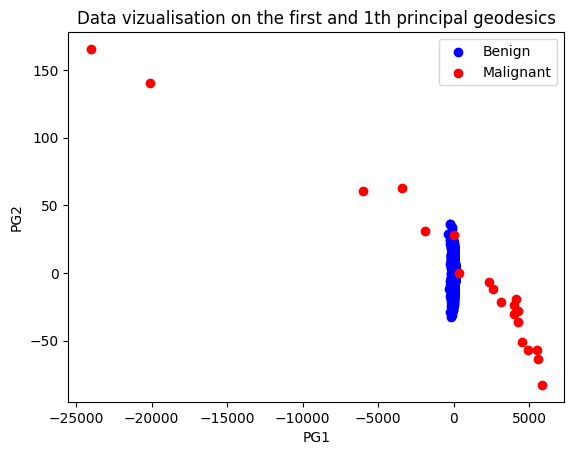

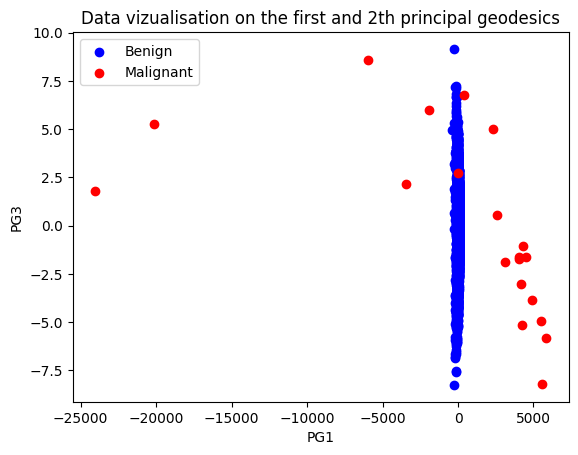

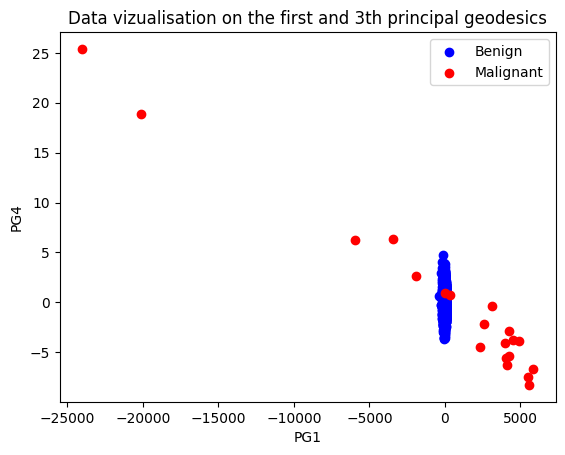

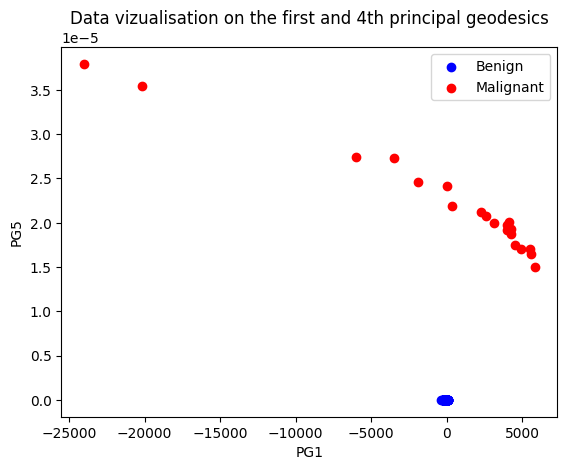

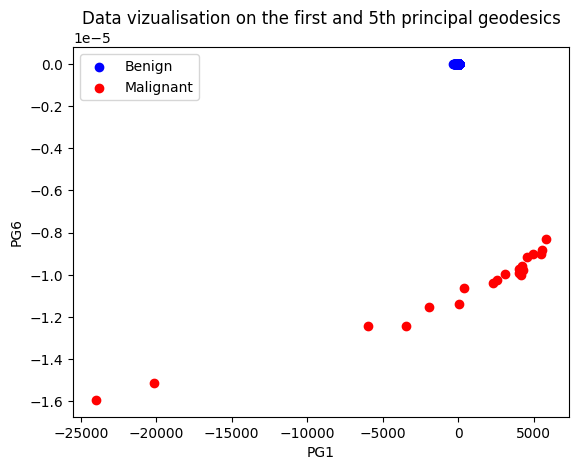

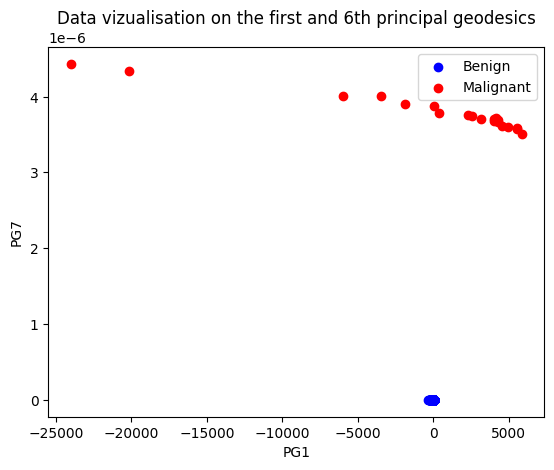

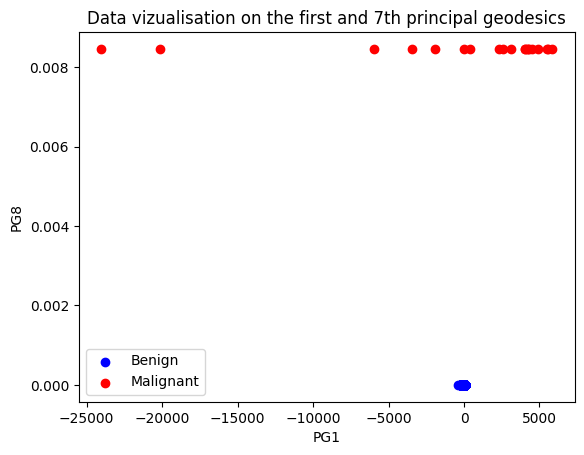

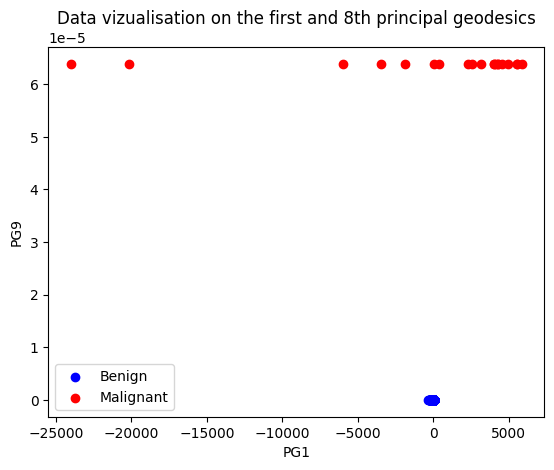

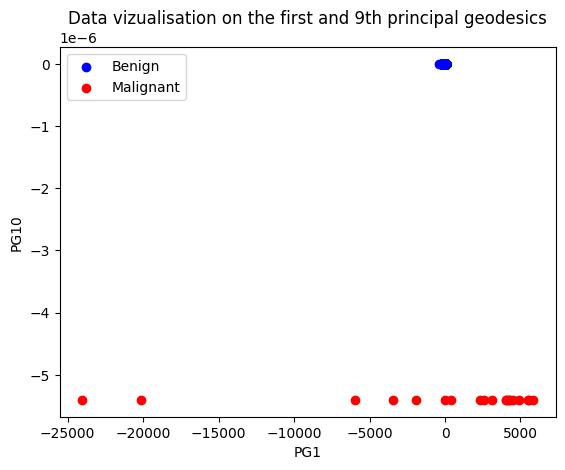

data 11


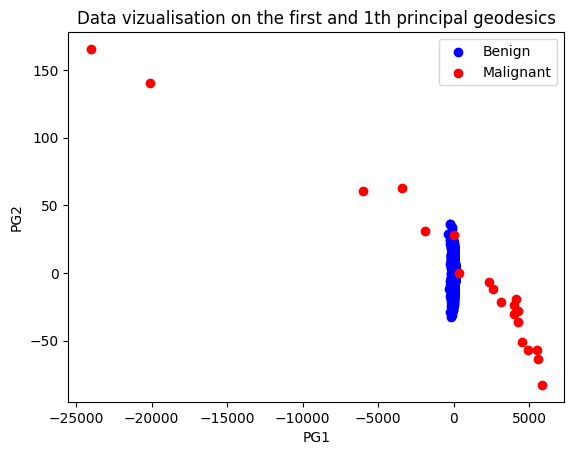

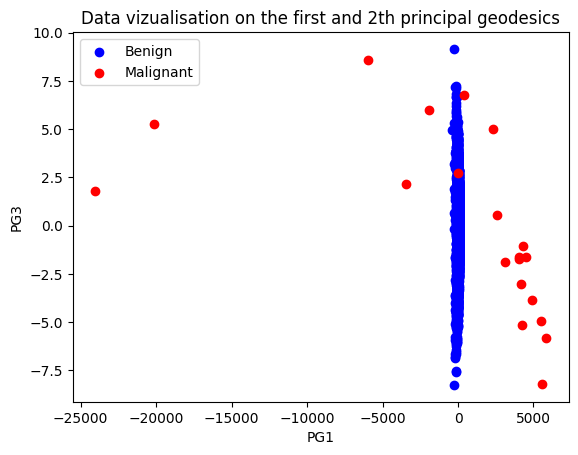

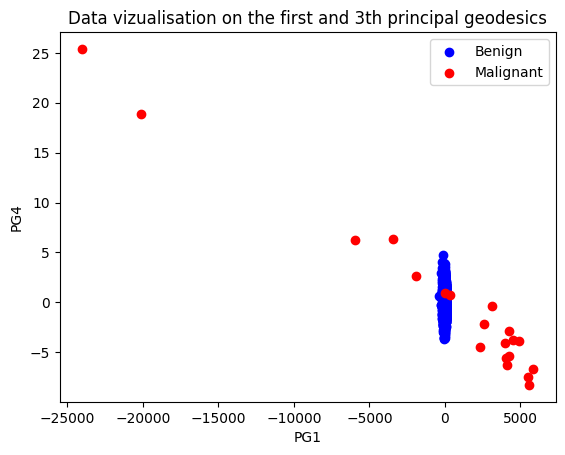

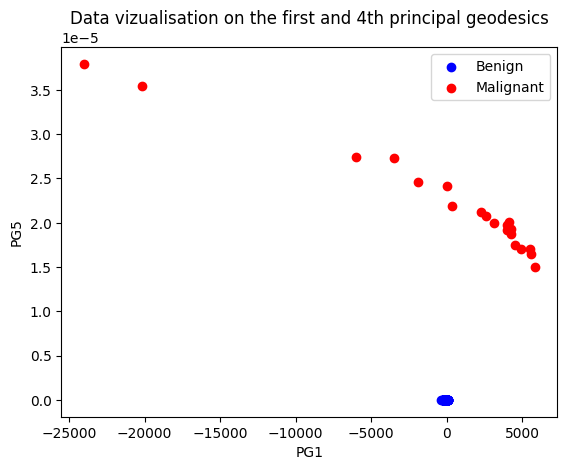

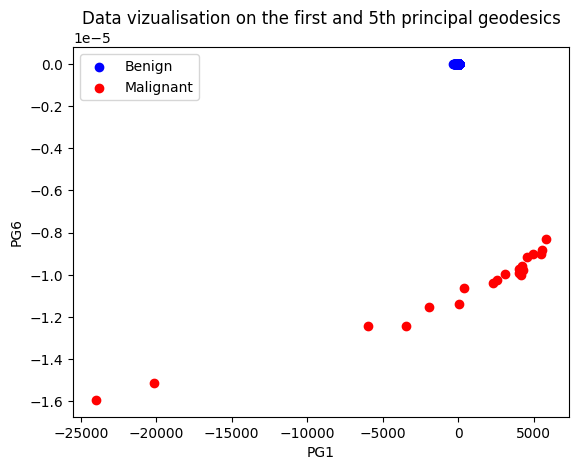

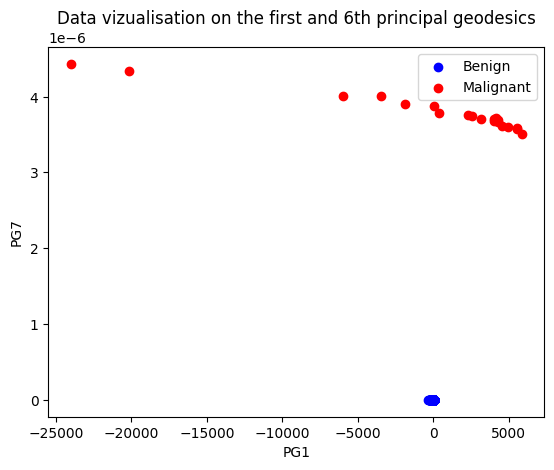

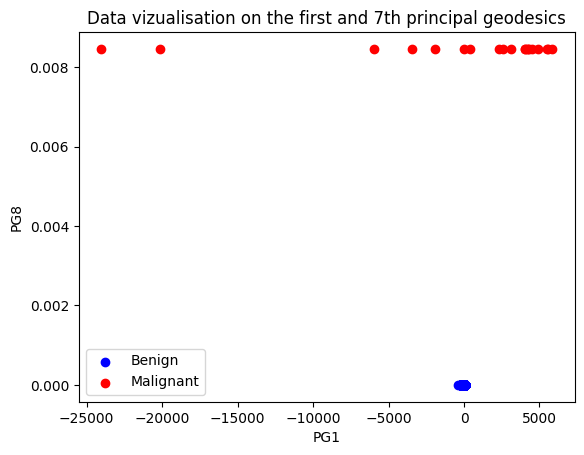

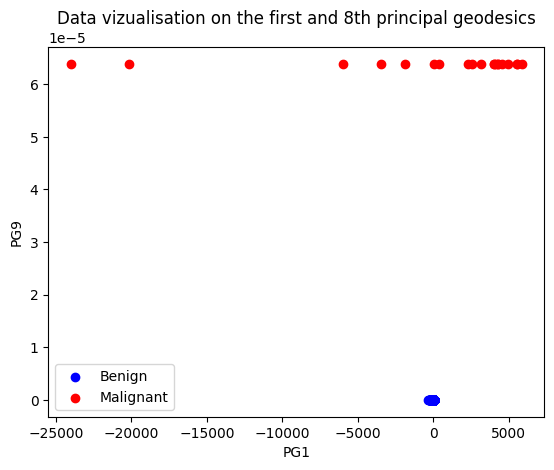

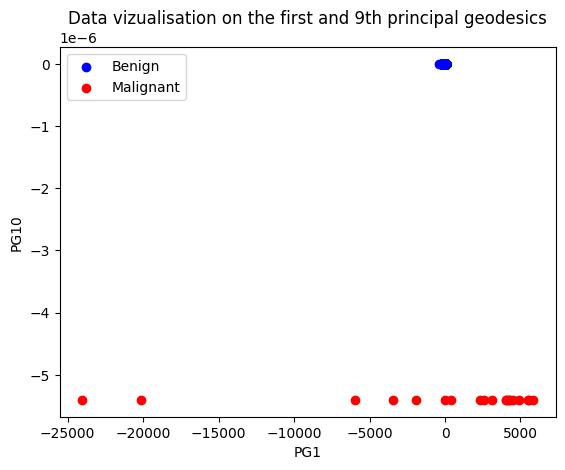

data 17


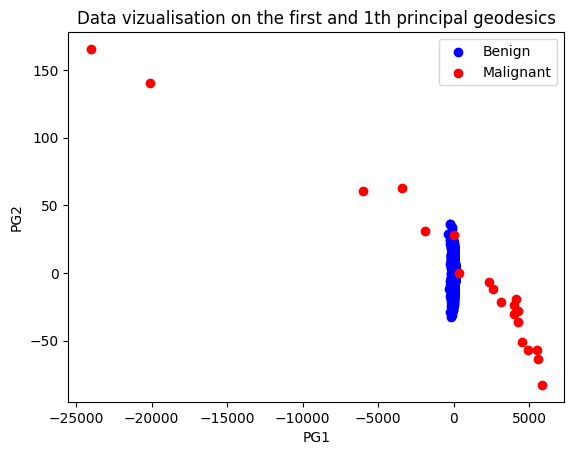

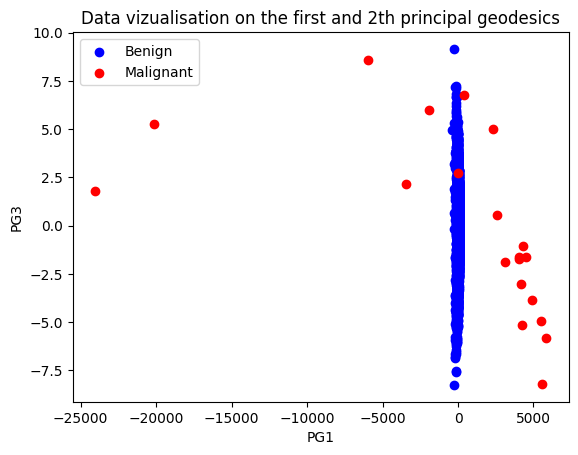

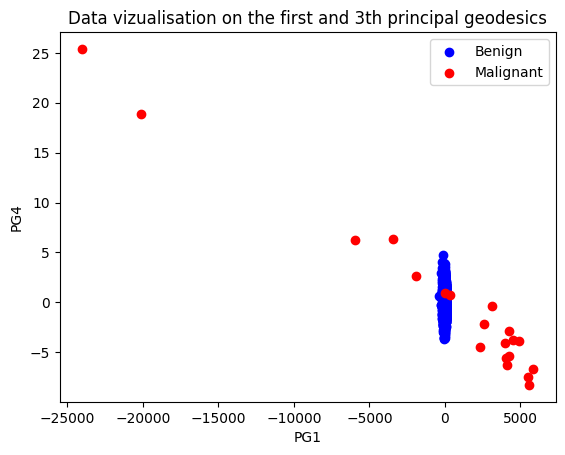

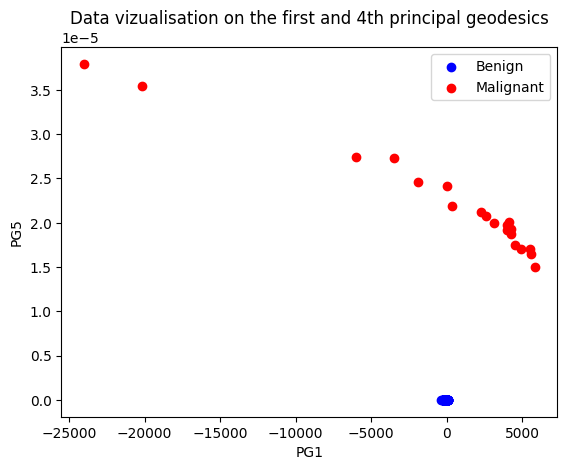

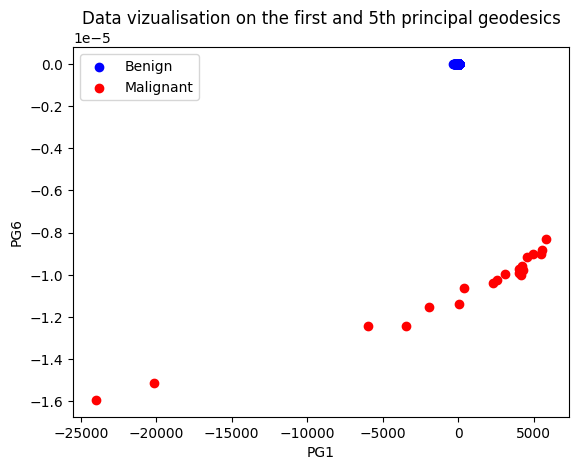

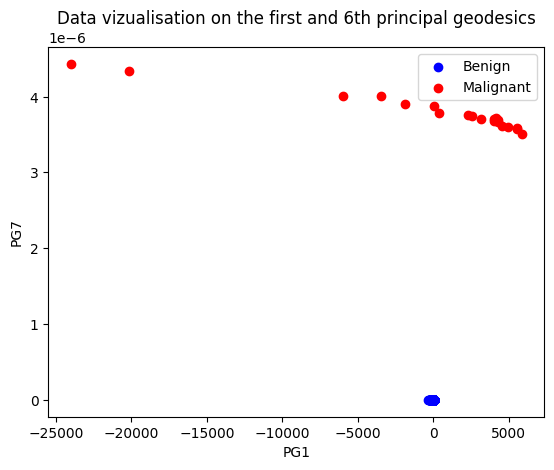

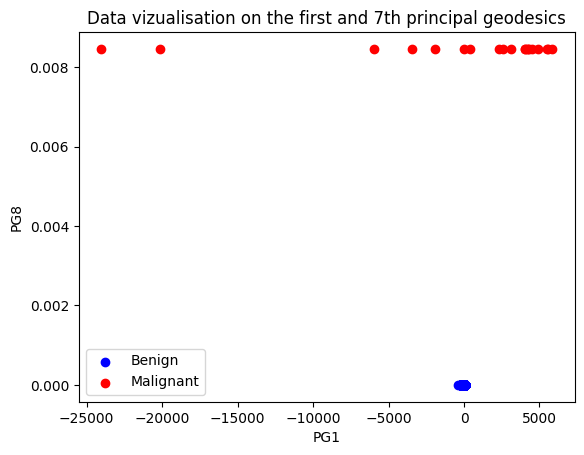

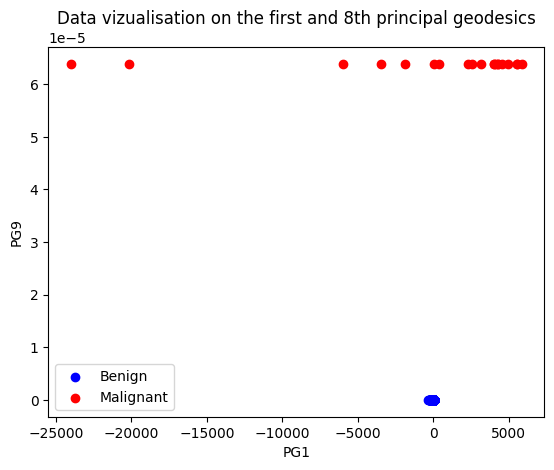

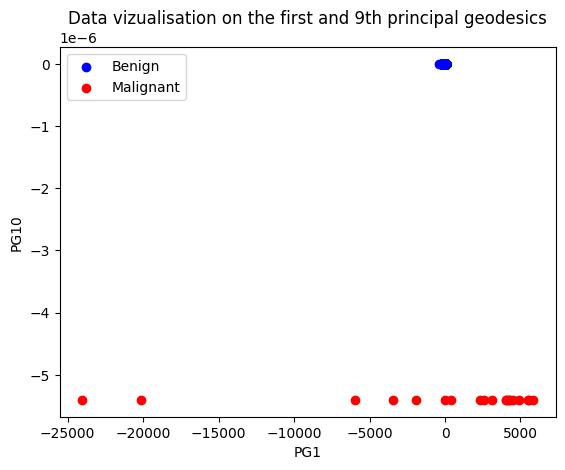

data 23


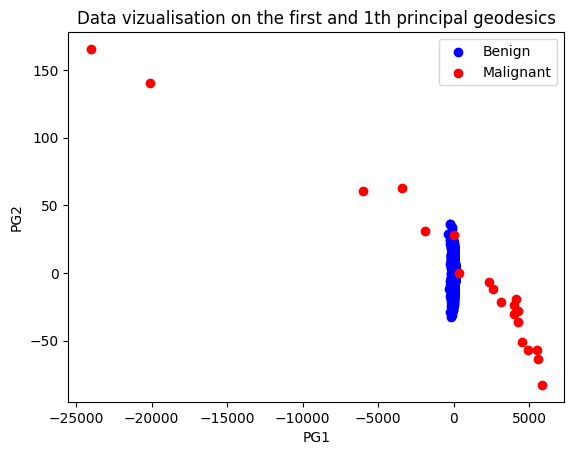

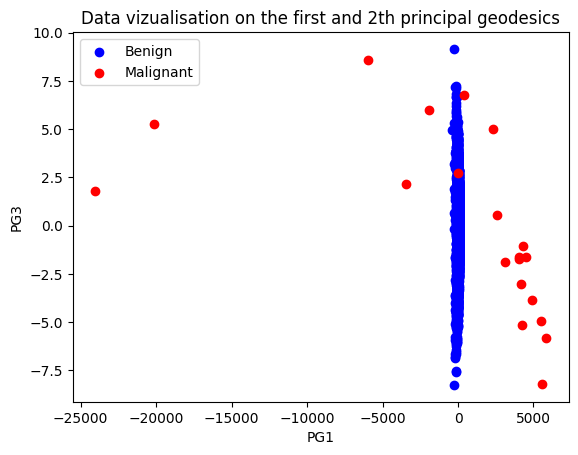

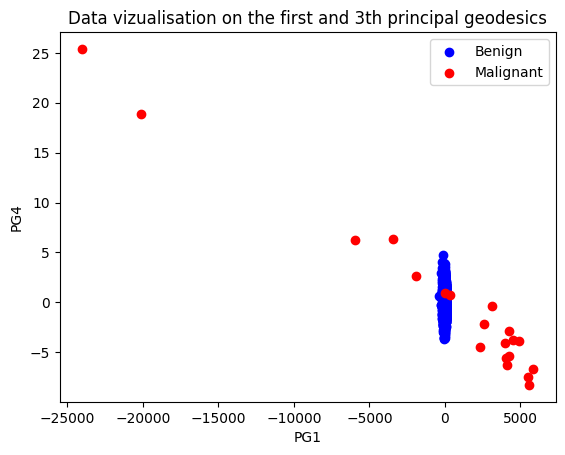

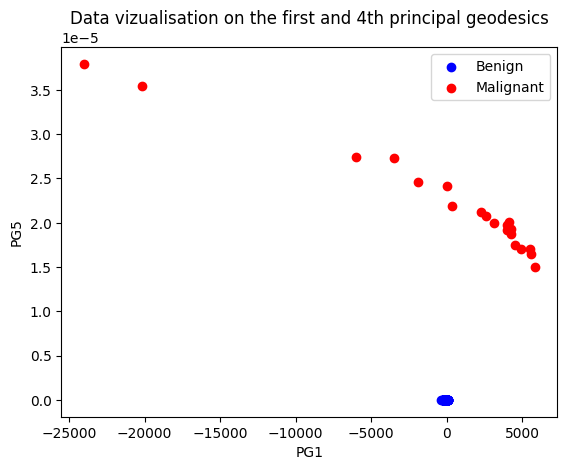

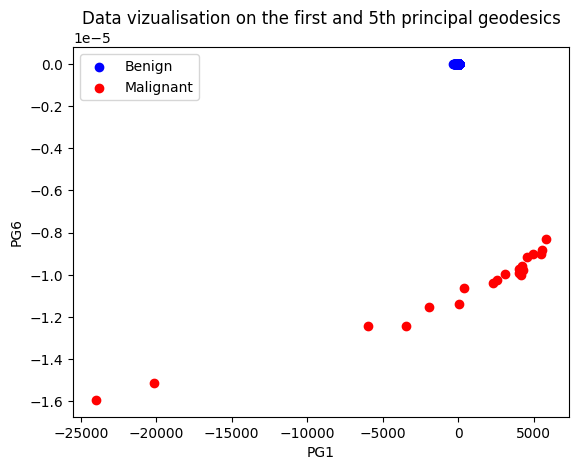

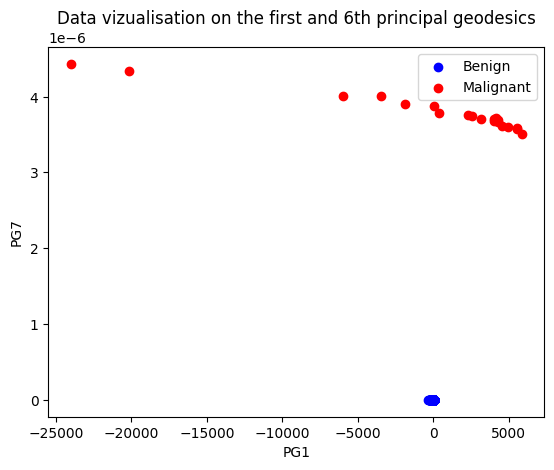

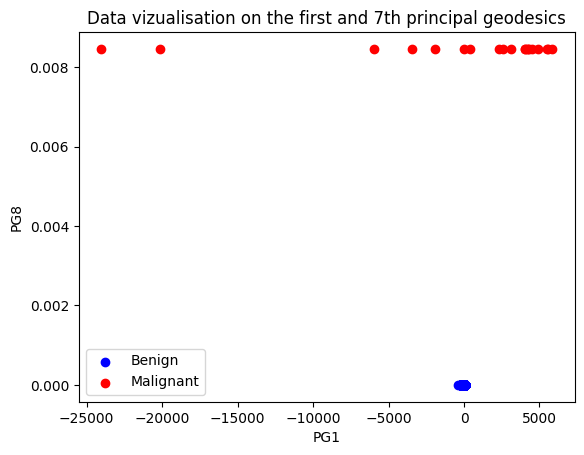

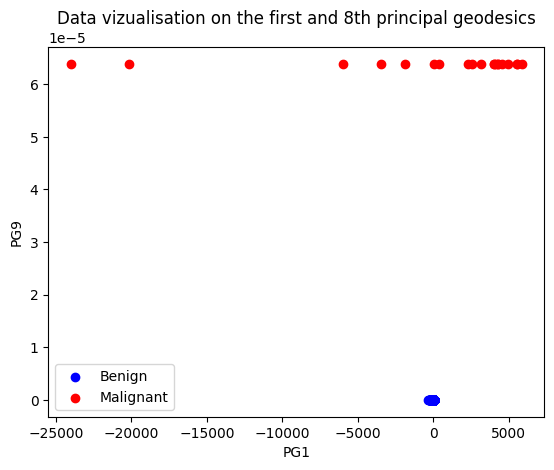

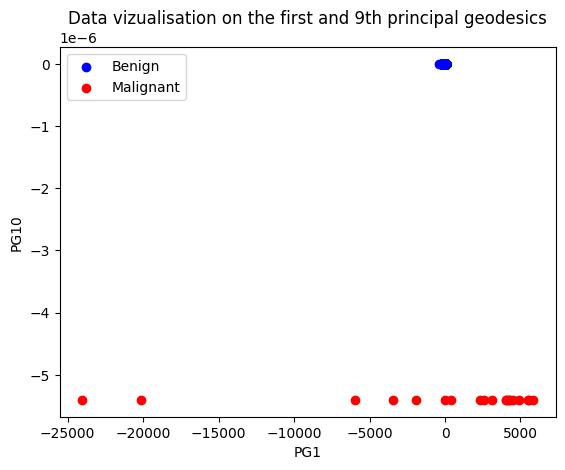

data 29


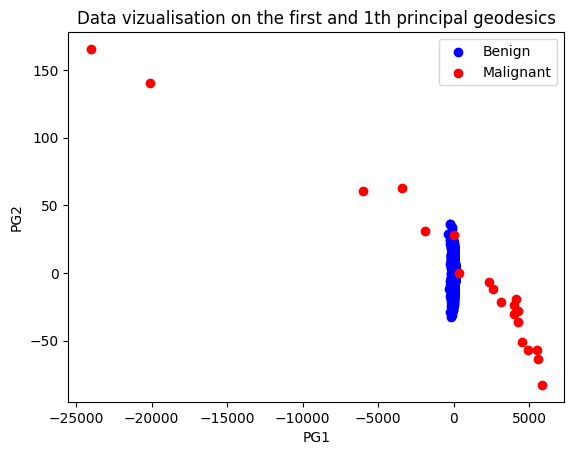

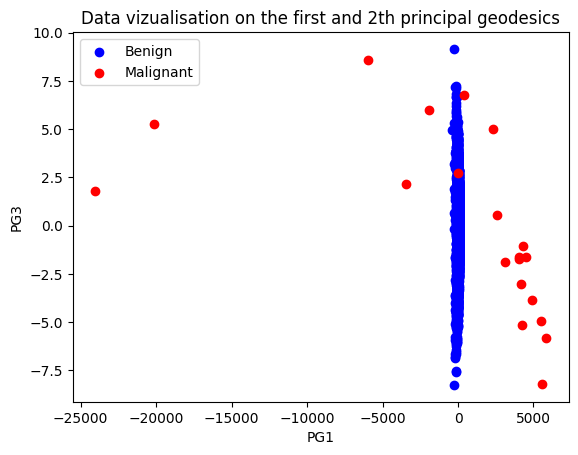

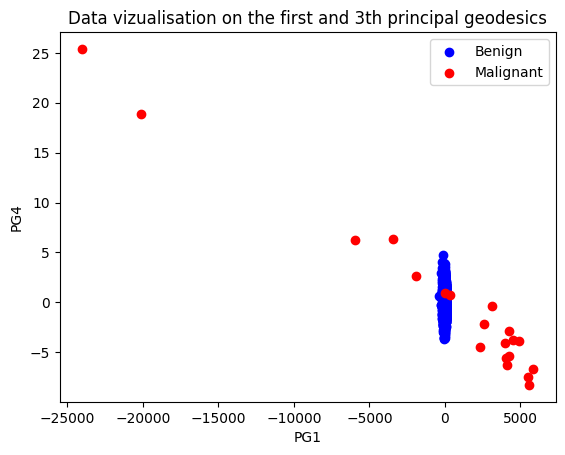

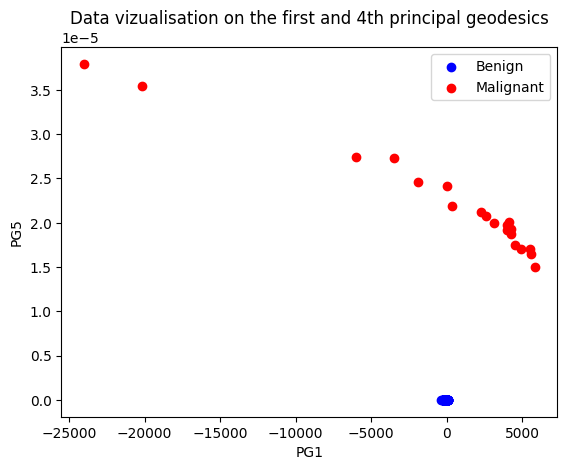

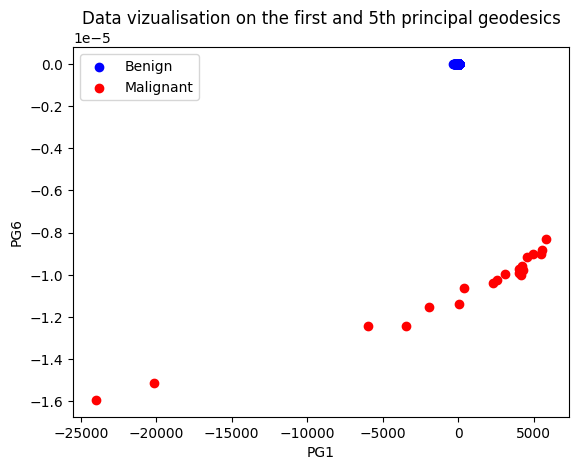

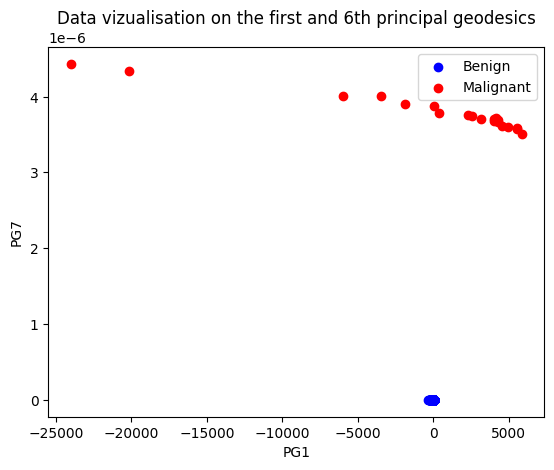

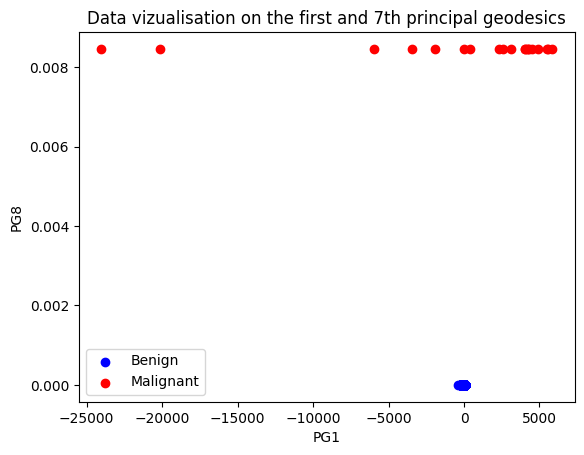

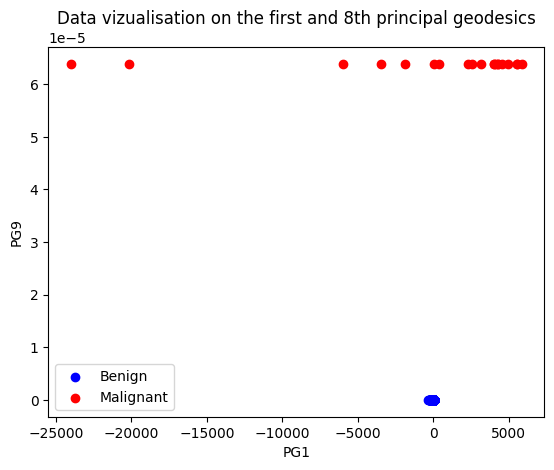

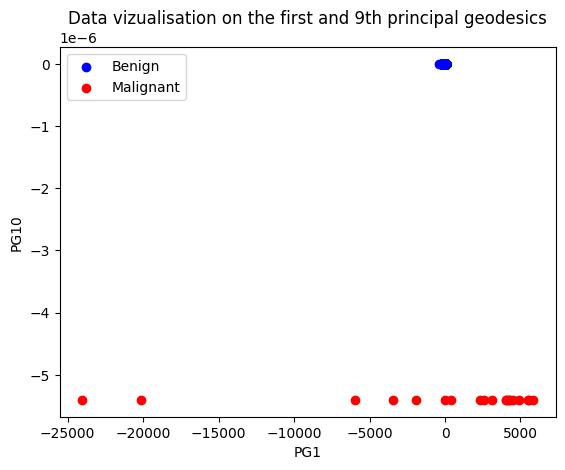

data 35


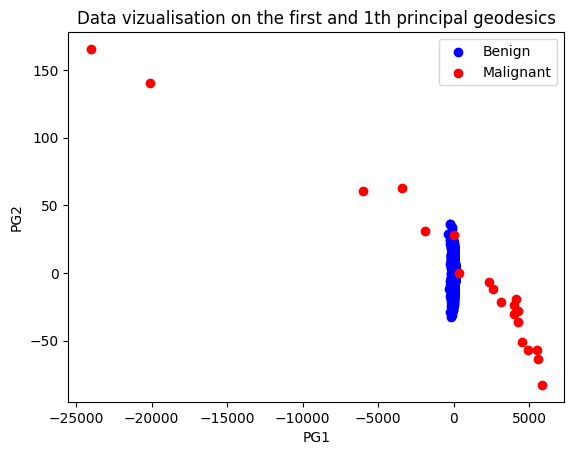

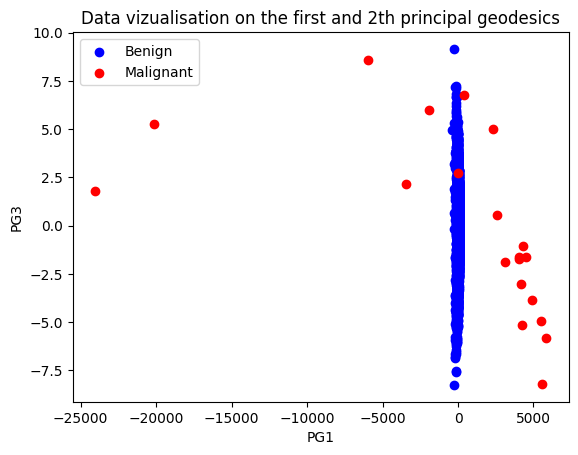

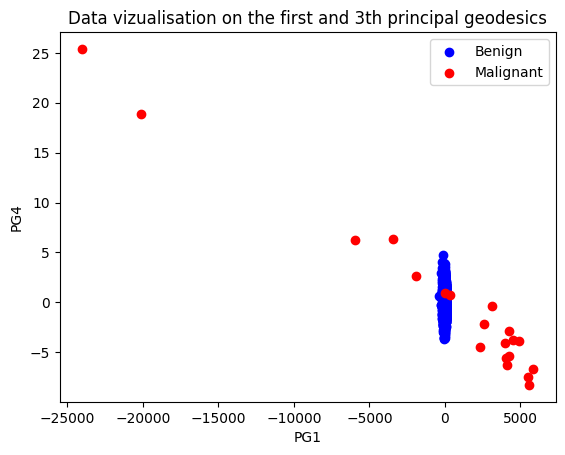

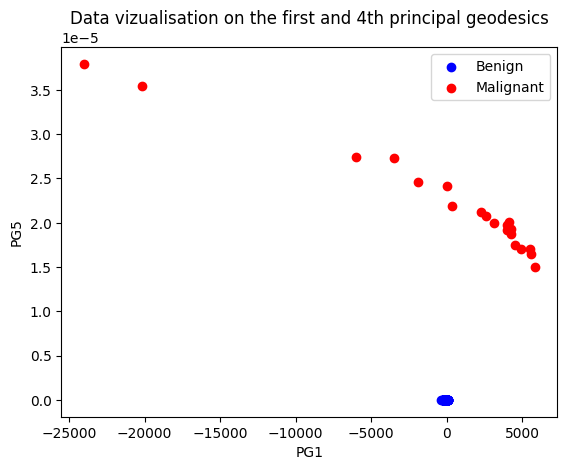

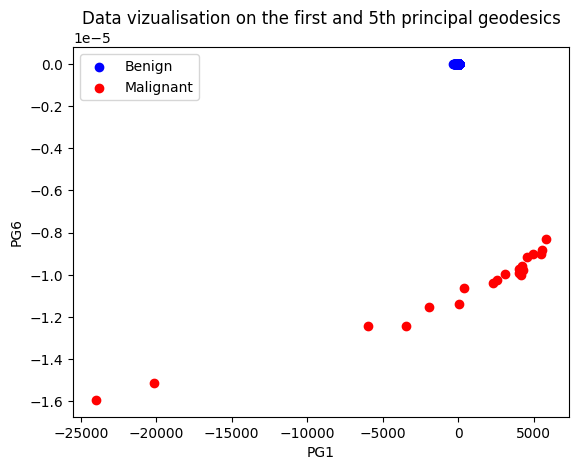

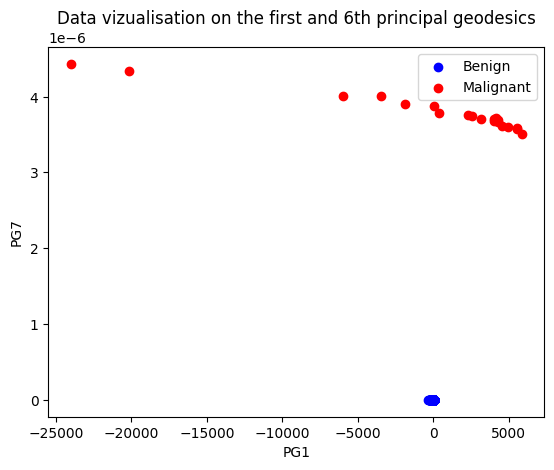

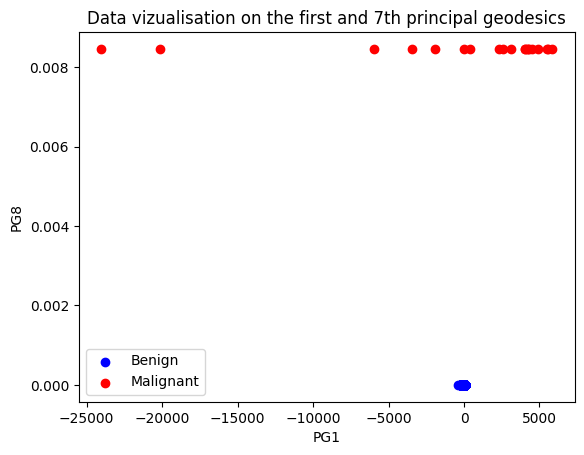

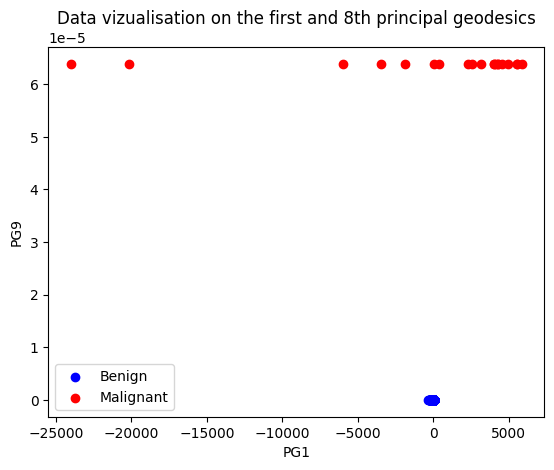

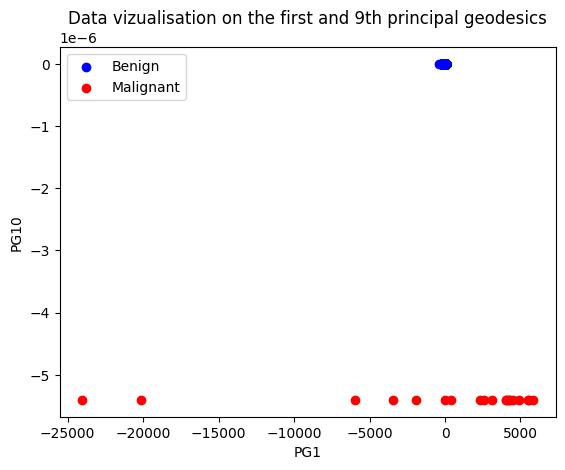

In [19]:
for i in list(6*np.arange(6)+5):
  print(f"data {i}")
  visualisation_all(projections_norm=projections_ben,projections_anorm=projections_mal[0],rate= 0,num=10)

In [81]:
idx_all = [i for i in range(100)]
for j in range(1,20):
  idx_all  += [1000*j + i for i in range(100)]

data_all = torch.cat((data_ben,data_mal))
t_principal_directions_all, signatures_all = compute_pga(path = data_all[:21000],sig_level=3,tangent=True,n_components=10)

Computing signatures
Computing tangent pga


In [82]:
idx_mal = [i for i in range(100)]
for j in range(1,36):
  idx_mal = idx_mal + [3000+j*1000+ i for i in range(10)]
idx_mal = np.array(idx_mal)

projections_ben = compute_projection(t_principal_directions_all,data_all[idx_all[:400]],channels = data_ben.shape[-1],depth = 3)


Computing tangent pga projections
Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0


<ipython-input-9-8bc71d05dc54>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Data #4 with component #0
Data #5 with component #0
Data #6 with component #0
Data #7 with component #0
Data #8 with component #0
Data #9 with component #0
Data #10 with component #0
Data #11 with component #0
Data #12 with component #0
Data #13 with component #0
Data #14 with component #0
Data #15 with component #0
Data #16 with component #0
Data #17 with component #0
Data #18 with component #0
Data #19 with component #0
Data #20 with component #0
Data #21 with component #0
Data #22 with component #0
Data #23 with component #0
Data #24 with component #0
Data #25 with component #0
Data #26 with component #0
Data #27 with component #0
Data #28 with component #0
Data #29 with component #0
Data #30 with component #0
Data #31 with component #0
Data #32 with component #0
Data #33 with component #0
Data #34 with component #0
Data #35 with component #0
Data #36 with component #0
Data #37 with component #0
Data #38 with component #0
Data #39 with component #0
Data #40 with component #0
Data #4

<ipython-input-9-8bc71d05dc54>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Data #174 with component #2
Data #175 with component #2
Data #176 with component #2
Data #177 with component #2
Data #178 with component #2
Data #179 with component #2
Data #180 with component #2
Data #181 with component #2
Data #182 with component #2
Data #183 with component #2
Data #184 with component #2
Data #185 with component #2
Data #186 with component #2
Data #187 with component #2
Data #188 with component #2
Data #189 with component #2
Data #190 with component #2
Data #191 with component #2
Data #192 with component #2
Data #193 with component #2
Data #194 with component #2
Data #195 with component #2
Data #196 with component #2
Data #197 with component #2
Data #198 with component #2
Data #199 with component #2
Data #200 with component #2
Data #201 with component #2
Data #202 with component #2
Data #203 with component #2
Data #204 with component #2
Data #205 with component #2
Data #206 with component #2
Data #207 with component #2
Data #208 with component #2
Data #209 with compo

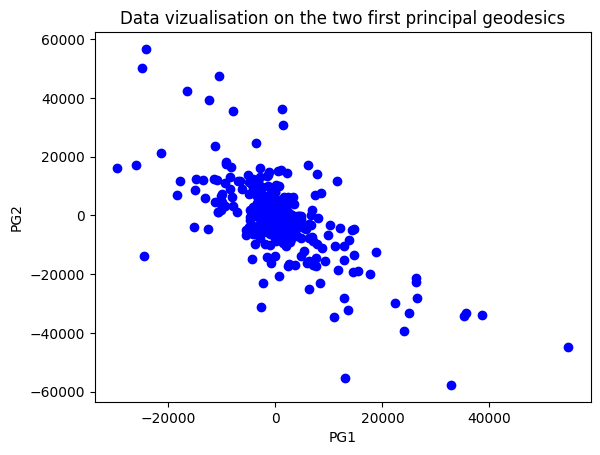

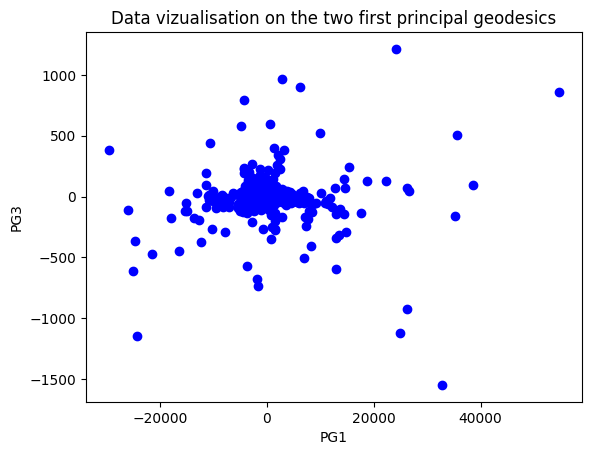

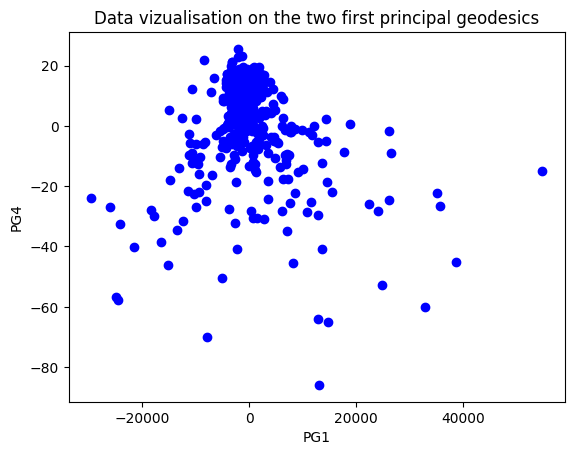

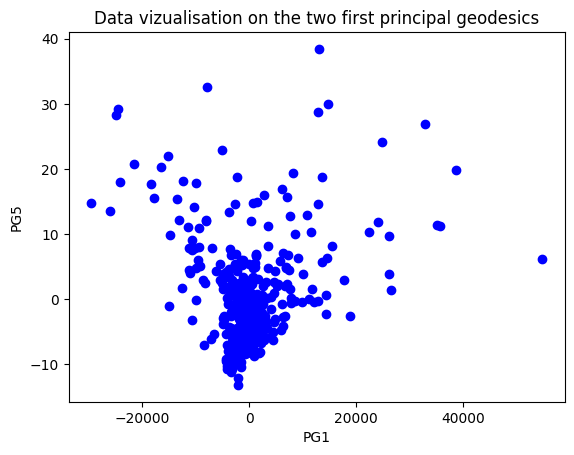

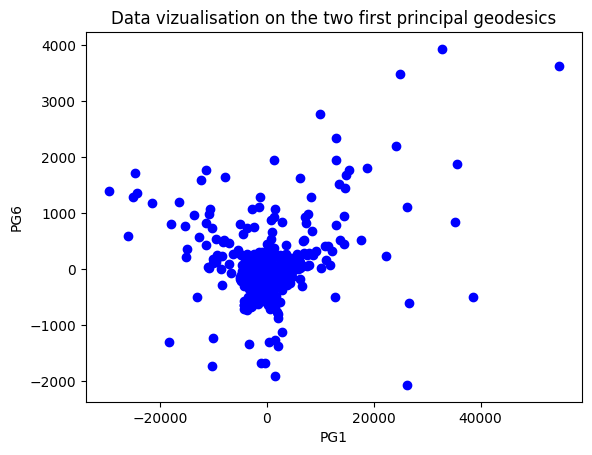

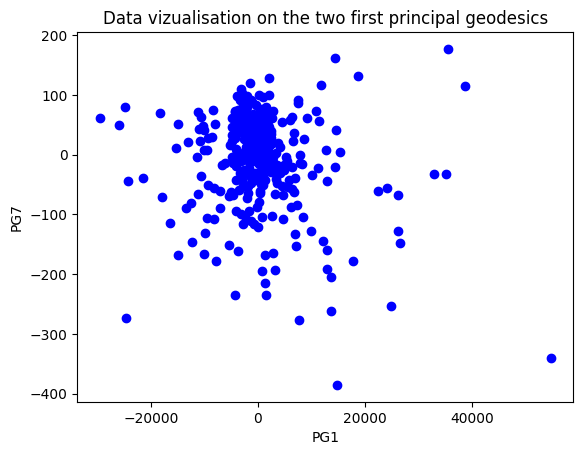

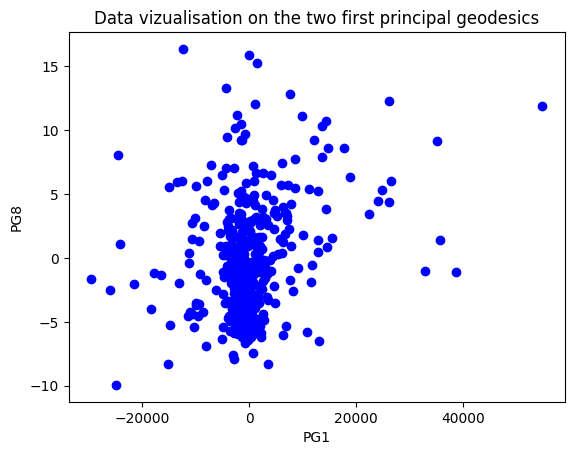

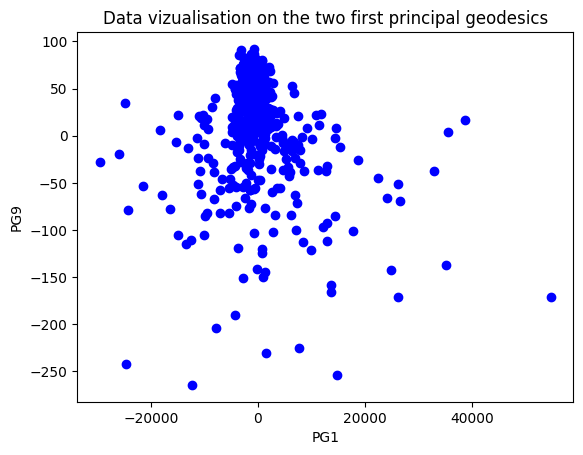

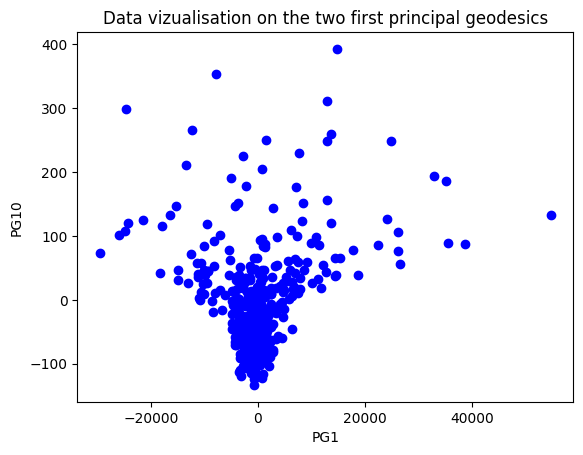

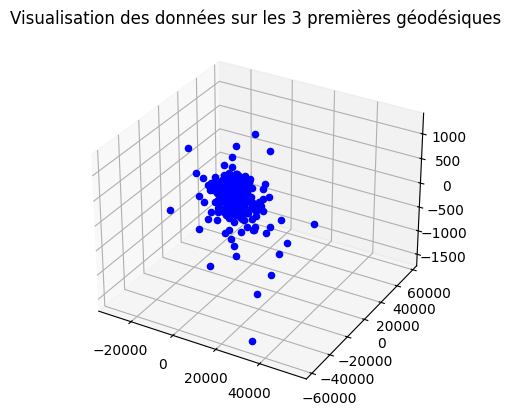

In [83]:
visualisation_normales(projections_ben,colour = ['blue']*400)

In [84]:
projections_mal = compute_projection(t_principal_directions_all,data_all[idx_all[400:]],channels = data_mal.shape[-1],depth = 3)

Computing tangent pga projections


<ipython-input-9-8bc71d05dc54>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Data #1401 with component #6
Data #1402 with component #6
Data #1403 with component #6
Data #1404 with component #6
Data #1405 with component #6
Data #1406 with component #6
Data #1407 with component #6
Data #1408 with component #6
Data #1409 with component #6
Data #1410 with component #6
Data #1411 with component #6
Data #1412 with component #6
Data #1413 with component #6
Data #1414 with component #6
Data #1415 with component #6
Data #1416 with component #6
Data #1417 with component #6
Data #1418 with component #6
Data #1419 with component #6
Data #1420 with component #6
Data #1421 with component #6
Data #1422 with component #6
Data #1423 with component #6
Data #1424 with component #6
Data #1425 with component #6
Data #1426 with component #6
Data #1427 with component #6
Data #1428 with component #6
Data #1429 with component #6
Data #1430 with component #6
Data #1431 with component #6
Data #1432 with compone

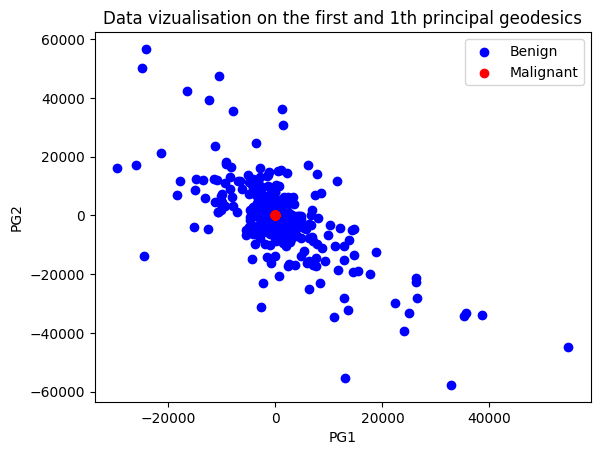

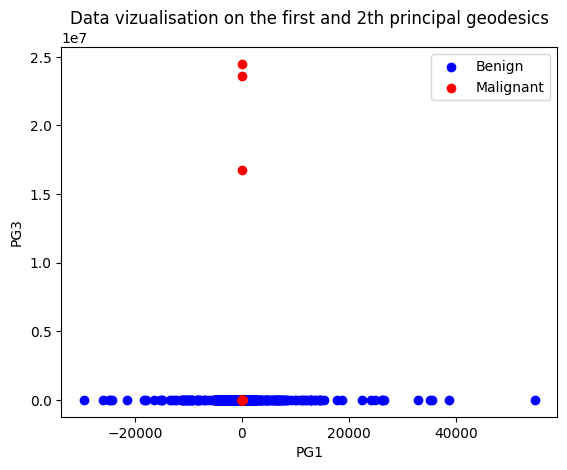

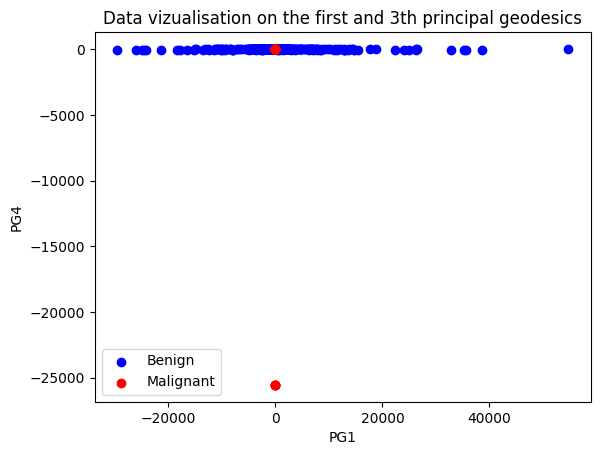

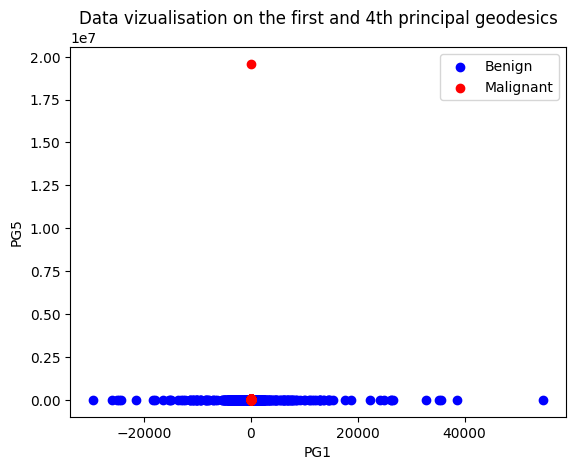

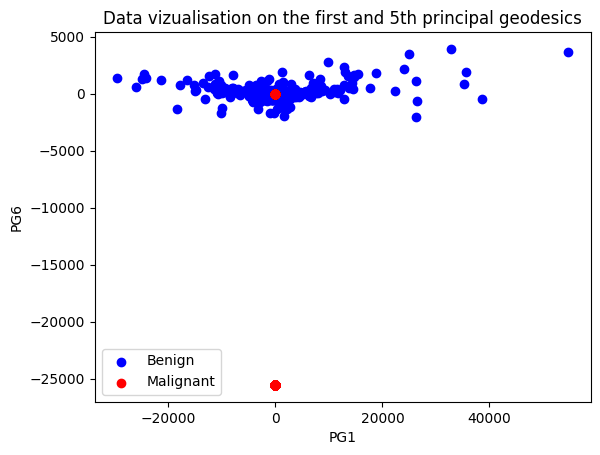

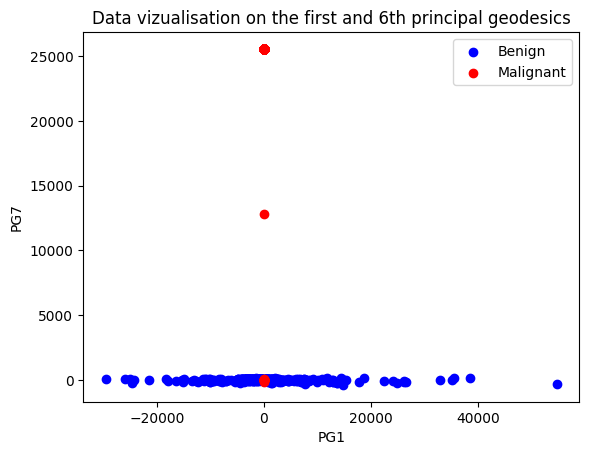

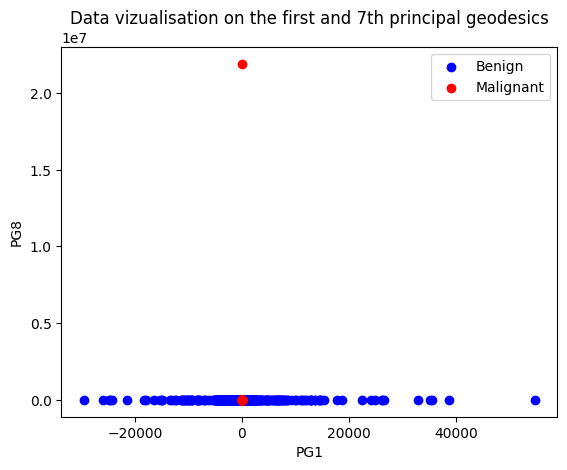

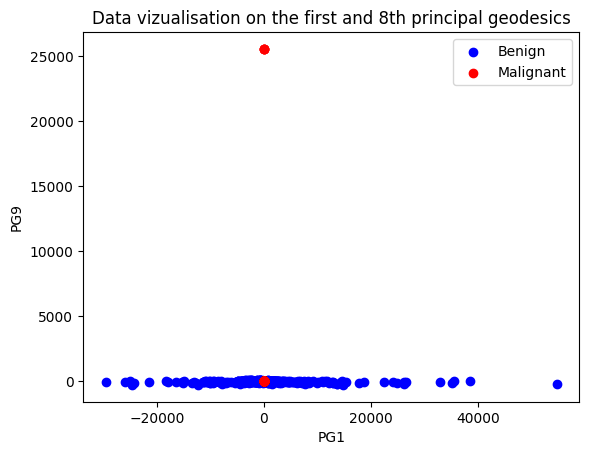

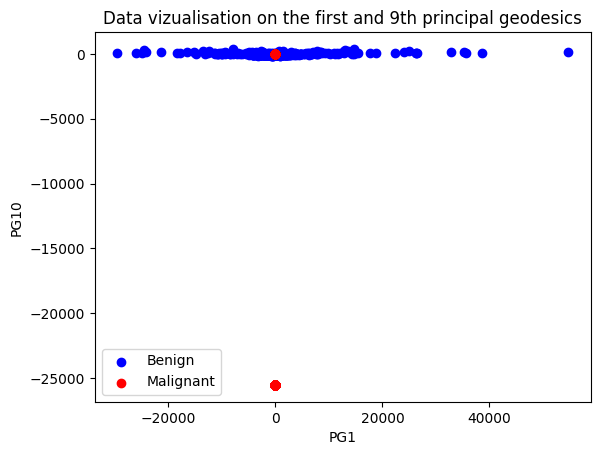

In [85]:
visualisation_all(projections_norm=projections_ben,projections_anorm=projections_mal,rate = 0,num = 700)